# Ciencia de Datos Aplicada: Proyecto Final
Este cuaderno será utilizado para el proyecto final correspondiente al curso "Ciencia de Datos Aplicada" impartido en Coursera.

## Introducción

Toronto y Nueva York son dos ciudades de fama internacional, con un sin fin de atractivos turisticos. Nuestro cliente esta interesado en aprovechar esta afluencia de público mediante la instalación de un establecimiento cuyo rubro sea "servicio de comida", sin embargo no esta seguro de a que subgrupo específico dedicarse ni en que zona de la ciudad establecerse. El objetivo de este informe es, mediante el estudio de dos sets de datos, establecer las categorías y lugares óptimos a elegir para satisfacer su demanda.

## Datos
Para desarrollar esto, se cuentan con dos sets de datos respecto a los distritos tanto de NY como de Toronto y el acceso a la base de datos de Foursquare para obtener los servicios que se ofrecen en dichas ciudades.

In [1]:
import numpy as np
import pandas as pd
import requests
import re
from bs4 import BeautifulSoup

Extraigo todo el código HTML del sitio y lo imprimo con tal de buscar las lineas de código que necesito

In [2]:
web_url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
response = requests.get(web_url)

Extraigo el fragmento necesario del código y lo convierto en un data frame para luego imprimirlo

In [3]:
soup = BeautifulSoup(response.text, 'html.parser')
table= soup.findAll('table')[0]
df = pd.read_html(str(table))[0]

Como las celdas del data frame anterior corresponden a strings, los separo para extraer la información necesaria. La información es almacenada en diccionarios teniendo cuidado de asingar np.nan a los valores "Not assigned".

In [4]:
j=0
Postal_Code = {}
Borough = {}
Neighborhood = {}
for i in range(len(df.iloc[0,:])):
    for place in df.iloc[:,i]:
        Postal_Code[j] = place[0:3]
        if place[3:] == "Not assigned":
            Borough[j] = np.nan
            Neighborhood[j] = np.nan
        else:
            S = place[0:place.find(')')].replace(" / ", ", ")
            Borough[j] = S[3:].split("(")[0]
            Neighborhood[j] = S.split("(")[1]
        j = j+1

Construyo un nuevo data frame basandome en los diccionarios para código posta, distrito y vecindario. Elimino las filas que contengan np.nan.

In [5]:
P = list(Postal_Code.values())
B = list(Borough.values())
N = list(Neighborhood.values())
table_df = pd.DataFrame(P)
table_df.columns = ["PostalCode"]
table_df['Borough'] = B
table_df['Neighborhood'] = N
table_df.dropna(subset=['Borough'], inplace=True)

In [6]:
table_df.shape

(103, 3)

Utilizamos este paquete para poder leer el archivo con los datos de longitud y latitud (no me función leerlo directamente con pandas). Imprimo la forma del archivo para corroborar que tiene la misma dimension que mi data frame original.

In [7]:
import io

In [8]:
URL = 'http://cocl.us/Geospatial_data'
r = requests.get(URL, allow_redirects=True)
data_file = io.StringIO(r.text)
ll = pd.read_csv(data_file)
ll.shape

(103, 3)

Inserto los datos de Latitud y Longitud

In [9]:
table_df["Latitude"] = ll["Latitude"]
table_df["Longitude"] = ll["Longitude"]
table_df.head(10)

,PostalCode,Borough,Neighborhood,Latitude,Longitude
1,M1B,Scarborough,"Malvern, Rouge",43.784535,-79.160497
2,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.763573,-79.188711
3,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.770992,-79.216917
4,M1G,Scarborough,Woburn,43.773136,-79.239476
5,M1H,Scarborough,Cedarbrae,43.744734,-79.239476
6,M1J,Scarborough,Scarborough Village,43.727929,-79.262029
7,M1K,Scarborough,"Kennedy Park, Ionview, East Birchmount Park",43.711112,-79.284577
8,M1L,Scarborough,"Golden Mile, Clairlea, Oakridge",43.716316,-79.239476
9,M1M,Scarborough,"Cliffside, Cliffcrest, Scarborough Village West",43.692657,-79.264848
10,M1N,Scarborough,"Birch Cliff, Cliffside West",43.757410,-79.273304


In [10]:
def fill_city(response,city,ll):
    try:
        a = range(len(response['results']))
    except:
        a = [0]
    for i in a: 
        try:
            fsq_id = response['results'][i]['fsq_id']
        except:
            fsq_id = np.nan

        try:
            Category_id = response['results'][i]['categories'][0]['id']
        except:
            Category_id = np.nan

        try:
            Category = response['results'][i]['categories'][0]['name']
        except:
            Category = np.nan

        try:
            Borough = response['results'][i]['location']['locality']
        except:
            Borough = np.nan

        try:
            Distance = response['results'][i]['distance']
        except:
            Distance = np.nan

        city = city.append({'fsq_id':fsq_id,'Category_id':Category_id,'Category':Category,'Borough':Borough,'Distance':Distance,'Ref':ll}, ignore_index=True)

    return city

In [11]:
columns = ['fsq_id','Category_id','Category','Borough','Distance','Ref']
Toronto = pd.DataFrame(columns=columns)

for j in range(len(table_df["Latitude"])):    
    neighborhood_latitude = table_df.iloc[j,3]
    neighborhood_longitude = table_df.iloc[j,4]
    LIMIT = 50 # limit of number of venues returned by Foursquare API
    radius = 500 # define radius
    ll = str(neighborhood_latitude) + "," + str(neighborhood_longitude)

    url = "https://api.foursquare.com/v3/places/search"
    params = {
      "ll":ll,
      "radius":radius,
      "sort":"DISTANCE",
      "limit":LIMIT  
    }
    headers = {
        "Accept": "application/json",
        "Authorization": "fsq3uXGuFt52TJnl7MeC/1Wm64gvxs60C4fcv/q1Cb2xuyA="
    }

    response = requests.request("GET", url, params=params, headers=headers).json()
    Toronto = fill_city(response,Toronto,ll)
Toronto.dropna(subset=['fsq_id','Category_id','Category','Borough','Distance','Ref'], inplace=True)
Toronto = Toronto.drop_duplicates(subset=['fsq_id'])
Toronto = Toronto[(Toronto['Category_id']>=13000) & (Toronto['Category_id']<14000)].reset_index()
Toronto.head()

,index,fsq_id,Category_id,Category,Borough,Distance,Ref
0,30,10103b2b0f34456fabf3ae6c,13064,Pizzeria,Scarborough,211,"43.7635726,-79.1887115"
1,34,7485f175aa1e4b9f71ad0467,13065,Restaurant,Scarborough,249,"43.7635726,-79.1887115"
2,36,6174b5dd763d48164d49f4d9,13065,Restaurant,Scarborough,254,"43.7635726,-79.1887115"
3,39,31b2cdeda7504c3015f9294f,13032,"Cafes, Coffee, and Tea Houses",Scarborough,264,"43.7635726,-79.1887115"
4,41,13a8fb2bfdff4e077e161df3,13145,Fast Food Restaurant,Scarborough,291,"43.7635726,-79.1887115"


In [12]:
Toronto.groupby(['Borough']).count()

,index,fsq_id,Category_id,Category,Distance,Ref
Borough,,,,,,
Don Mills,1,1,1,1,1,1
Etobicoke,17,17,17,17,17,17
Mississauga,9,9,9,9,9,9
North York,23,23,23,23,23,23
Scarborough,46,46,46,46,46,46
Toronto,404,404,404,404,404,404
Unionville,1,1,1,1,1,1
Vaughan,1,1,1,1,1,1
York,7,7,7,7,7,7


In [13]:
import json
NY_url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs/newyork_data.json'
NYresponse = requests.get(NY_url).json()
NY_data = NYresponse['features']
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude']
neighborhoods = pd.DataFrame(columns=column_names)

In [14]:
for data in NY_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [15]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [16]:
columns = ['fsq_id','Category_id','Category','Borough','Distance','Ref']
NY = pd.DataFrame(columns=columns)

for j in range(len(neighborhoods['Latitude'])):    
    neighborhood_latitude = neighborhoods.iloc[j,2]
    neighborhood_longitude = neighborhoods.iloc[j,3]
    LIMIT = 50 # limit of number of venues returned by Foursquare API
    radius = 500 # define radius
    ll = str(neighborhood_latitude) + "," + str(neighborhood_longitude)

    url = "https://api.foursquare.com/v3/places/search"
    params = {
      "ll":ll,
      "radius":radius,
      "sort":"DISTANCE",
      "limit":LIMIT  
    }
    headers = {
        "Accept": "application/json",
        "Authorization": "fsq3uXGuFt52TJnl7MeC/1Wm64gvxs60C4fcv/q1Cb2xuyA="
    }

    response = requests.request("GET", url, params=params, headers=headers).json()
    NY = fill_city(response,NY,ll)
NY.dropna(subset=['fsq_id','Category_id','Category','Borough','Distance','Ref'], inplace=True)
NY = NY.drop_duplicates(subset=['fsq_id'])
NY = NY[(NY['Category_id']>=13000) & (NY['Category_id']<14000)].reset_index()
NY.head()

,index,fsq_id,Category_id,Category,Borough,Distance,Ref
0,1,4c537892fd2ea593cb077a28,13046,Ice Cream Parlor,Bronx,127,"40.89470517661,-73.84720052054902"
1,21,4f32458019836c91c7c734ff,13039,Deli,Bronx,326,"40.89470517661,-73.84720052054902"
2,23,6f93e0c92a9b44cf1c61f9c2,13065,Restaurant,New York,331,"40.89470517661,-73.84720052054902"
3,40,537cb882438c4dd02a4eddbe,13065,Restaurant,Bronx,417,"40.89470517661,-73.84720052054902"
4,49,763c9059e609468d24d2e6ab,13064,Pizzeria,Bronx,445,"40.89470517661,-73.84720052054902"


In [17]:
NY = NY.drop('index',axis=1)
NY.head()

,fsq_id,Category_id,Category,Borough,Distance,Ref
0,4c537892fd2ea593cb077a28,13046,Ice Cream Parlor,Bronx,127,"40.89470517661,-73.84720052054902"
1,4f32458019836c91c7c734ff,13039,Deli,Bronx,326,"40.89470517661,-73.84720052054902"
2,6f93e0c92a9b44cf1c61f9c2,13065,Restaurant,New York,331,"40.89470517661,-73.84720052054902"
3,537cb882438c4dd02a4eddbe,13065,Restaurant,Bronx,417,"40.89470517661,-73.84720052054902"
4,763c9059e609468d24d2e6ab,13064,Pizzeria,Bronx,445,"40.89470517661,-73.84720052054902"


In [18]:
NY.groupby(['Borough']).count()

,fsq_id,Category_id,Category,Distance,Ref
Borough,,,,,
Arverne,9,9,9,9,9
Astoria,51,51,51,51,51
Bayside,20,20,20,20,20
Bedford-Stuyvesant,1,1,1,1,1
Beechhurst,1,1,1,1,1
Belle Harbor,4,4,4,4,4
Bellerose,3,3,3,3,3
Breezy Point,5,5,5,5,5
Briarwood,2,2,2,2,2


## Metodología
Para comenzar, se busca establecer si es que los establecimientos que prestan servicios de comida se concentran en algun distrito en particular o si es que se distribuyen uniformemente tanto en Toronto como en NY.

In [19]:
Toronto_freq = pd.DataFrame({'count' : Toronto.groupby(['Borough'])['fsq_id'].size()}).reset_index()
Toronto_freq.sort_values(['count'],ascending=False,inplace=True)
Toronto_freq.head(9)

,Borough,count
5,Toronto,404
4,Scarborough,46
3,North York,23
1,Etobicoke,17
2,Mississauga,9
8,York,7
0,Don Mills,1
6,Unionville,1
7,Vaughan,1


In [20]:
NY_freq = pd.DataFrame({'count' : NY.groupby(['Borough'])['fsq_id'].size()}).reset_index()
NY_freq.sort_values(['count'],ascending=False,inplace=True)
NY_freq.head(9)

,Borough,count
40,New York,1167
11,Brooklyn,885
10,Bronx,489
55,Staten Island,344
22,Flushing,84
43,Queens,72
31,Jamaica,64
1,Astoria,51
15,Corona,34


Dado lo anterior, se pretenden estudiar los distritos que tengan una mayor cantidad de establecimientos. En el caso de Toronto, solo se analizará el distrito de Toronto dada la diferencia en frecuencia con los otros distritos. Por otra parte, en NY se tomarán los distritos de New York y Brooklyn siguiendo la misma justificación. Cabe señalar que lo que se estudia es un espacio muestral de todos los establecimientos por distrito: Para esto, se fijó un radio de 500 m a partir del centro de cada vecindario en cada distrito para luego extraer de la base de datos de FourSquare la cantidad de establecimientos que cumplen con los requisitos. Posteriormente, se agruparon los datos por distrito con tal de establecer que distrito es más popular a la hora de abrir un establecimiento en el rubro de la comida (entiendase por comida todo establecimiento que ofrece productos tanto comestibles como bebestibles).

## Resultados
A continuación, se presentan los principales resultados del estudio:

In [21]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt

La siguiente tabla contiene la cantidad de establecimientos presentes en los diferentes distritos de la ciudad de Toronto:

In [22]:
Toronto_freq_6 = Toronto_freq[Toronto_freq['count']>Toronto_freq.iloc[4,1]]
Toronto_freq_6 = Toronto_freq_6.append({'Borough':'Others','count':Toronto_freq[Toronto_freq['count']<=Toronto_freq.iloc[4,1]].sum()['count']},ignore_index=True)
Toronto_freq_6

,Borough,count
0,Toronto,404
1,Scarborough,46
2,North York,23
3,Etobicoke,17
4,Others,19


La siguiente tabla presenta la misma situación pero para la ciudad de Nueva York:

In [23]:
NY_freq_6 = NY_freq[NY_freq['count']>NY_freq.iloc[5,1]]
NY_freq_6 = NY_freq_6.append({'Borough':'Others','count':NY_freq[NY_freq['count']<=NY_freq.iloc[5,1]].sum()['count']},ignore_index=True)
NY_freq_6

,Borough,count
0,New York,1167
1,Brooklyn,885
2,Bronx,489
3,Staten Island,344
4,Flushing,84
5,Others,715


In [24]:
def plot_place(df,name):
    df['count'].plot(kind='pie',
                            figsize=(15, 6),
                            autopct='%1.1f%%', 
                            startangle=90,    
                            shadow=True,       
                            labels=None,         
                            pctdistance=1.12,     
                            )
    title = 'Establecimientos en {}'.format(name)
    plt.title(title, y=1.12)
    plt.axis('equal')
    plt.legend(labels=df.iloc[:,0], loc='upper left')
    plt.show()
    None

Gráfico circular que muestra la distribución de establecimientos en los diferentes distritos:

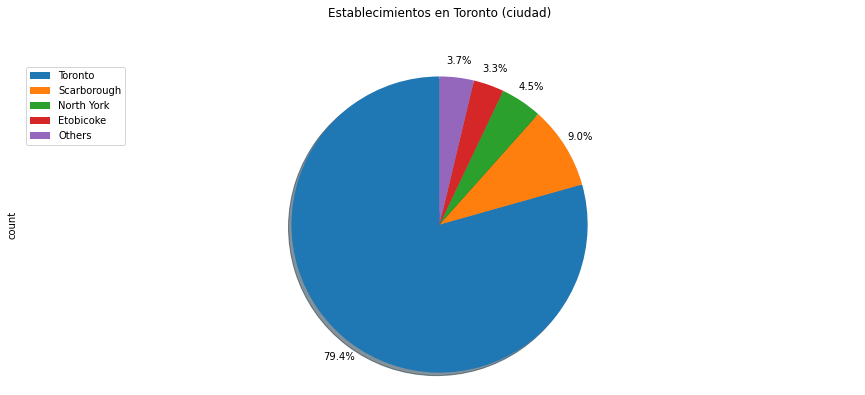

In [25]:
plot_place(Toronto_freq_6,'Toronto (ciudad)')

Gráfico que muestra la misma distribución anterior para la ciudad de Nueva York:

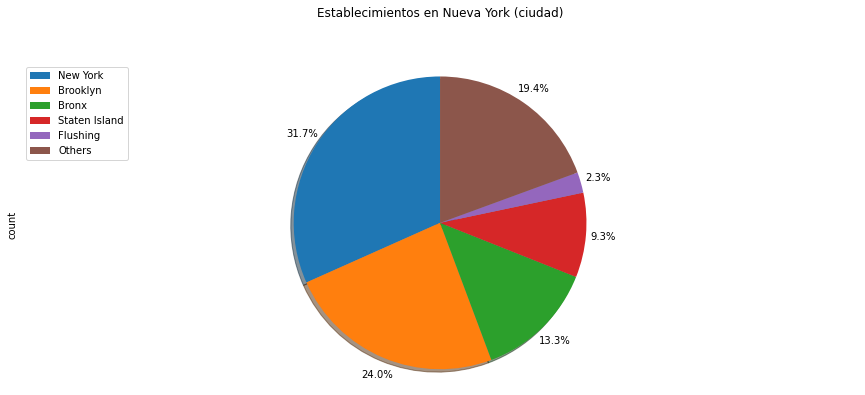

In [26]:
plot_place(NY_freq_6,'Nueva York (ciudad)')

Para Toronto: El distrito que concentra la mayoría de establecimientos corresponde al Distrito Toronto. \
Para Nueva York: Los distritos que concentran la mayoría de establecimientos son New York, Brooklyn y Bronx.

La siguiente tabla presenta la cantidad de establecimientos por categoría para el distrito de Toronto:

In [49]:
D_Toronto = Toronto[Toronto['Borough'] == 'Toronto']
District_Toronto = pd.DataFrame({'count' : D_Toronto.groupby(['Category'])['fsq_id'].size()}).reset_index()
filt1 = ~District_Toronto['Category'].str.contains('Restaurant')
filt2 = ~District_Toronto['Category'].str.contains('Caf')
filt3 = ~District_Toronto['Category'].str.contains('Bar')
District_Toronto = District_Toronto[filt1 & filt2 & filt3]
Rest = pd.DataFrame({'count':D_Toronto[D_Toronto['Category'].str.contains('Restaurant')].groupby(['Category'])['fsq_id'].size()}).reset_index()
Restaurant = Rest['count'].sum()
Caf = pd.DataFrame({'count':D_Toronto[D_Toronto['Category'].str.contains('Caf')].groupby(['Category'])['fsq_id'].size()}).reset_index()
Cafe = Caf['count'].sum()
B = pd.DataFrame({'count':D_Toronto[D_Toronto['Category'].str.contains('Bar')].groupby(['Category'])['fsq_id'].size()}).reset_index()
Bar = B['count'].sum()
District_Toronto = District_Toronto.append({'Category':'Restaurant','count':Restaurant},ignore_index=True)
District_Toronto = District_Toronto.append({'Category':'Cafe','count':Cafe},ignore_index=True)
District_Toronto = District_Toronto.append({'Category':'Bar','count':Bar},ignore_index=True)
District_Toronto.sort_values(['count'],ascending=False,inplace=True)
District_Toronto.head(9)

,Category,count
27,Restaurant,153
28,Cafe,51
29,Bar,37
1,Bakery,22
21,Pizzeria,21
9,Deli,18
11,Diner,15
8,Coffee Shop,14
7,Burger Joint,10


Gráfico circular que representa la cantidad porcentual de establecimientos en el distrito de Toronto:

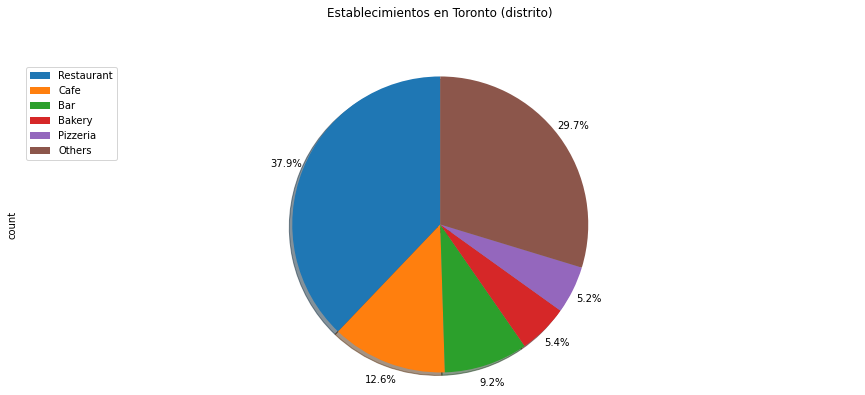

In [70]:
District_Toronto_6 = District_Toronto[District_Toronto['count']>District_Toronto.iloc[5,1]]
District_Toronto_6 = District_Toronto_6.append({'Category':'Others','count':District_Toronto[District_Toronto['count']<=District_Toronto.iloc[5,1]].sum()['count']},ignore_index=True)
plot_place(District_Toronto_6,'Toronto (distrito)')

La siguiente tabla presenta la cantidad de establecimientos por categoría para el distrito de Nueva York:

In [54]:
D_NY = NY[NY['Borough'] == 'New York']
District_New_York = pd.DataFrame({'count' : D_NY.groupby(['Category'])['fsq_id'].size()}).reset_index()
filt1 = ~District_New_York['Category'].str.contains('Restaurant')
filt2 = ~District_New_York['Category'].str.contains('Caf')
filt3 = ~District_New_York['Category'].str.contains('Bar')
District_New_York = District_New_York[filt1 & filt2 & filt3]
Rest = pd.DataFrame({'count':D_NY[D_NY['Category'].str.contains('Restaurant')].groupby(['Category'])['fsq_id'].size()}).reset_index()
Restaurant = Rest['count'].sum()
Caf = pd.DataFrame({'count':D_NY[D_NY['Category'].str.contains('Caf')].groupby(['Category'])['fsq_id'].size()}).reset_index()
Cafe = Caf['count'].sum()
B = pd.DataFrame({'count':D_NY[D_NY['Category'].str.contains('Bar')].groupby(['Category'])['fsq_id'].size()}).reset_index()
Bar = B['count'].sum()
District_New_York = District_New_York.append({'Category':'Restaurant','count':Restaurant},ignore_index=True)
District_New_York = District_New_York.append({'Category':'Cafe','count':Cafe},ignore_index=True)
District_New_York = District_New_York.append({'Category':'Bar','count':Bar},ignore_index=True)
District_New_York.sort_values(['count'],ascending=False,inplace=True)
District_New_York.head(9)

,Category,count
28,Restaurant,504
30,Bar,163
2,Bakery,67
9,Coffee Shop,66
22,Pizzeria,62
29,Cafe,58
10,Deli,57
1,Bagel Shop,34
8,Burger Joint,33


Gráfico circular que representa la cantidad porcentual de establecimientos en el distrito de Nueva York:

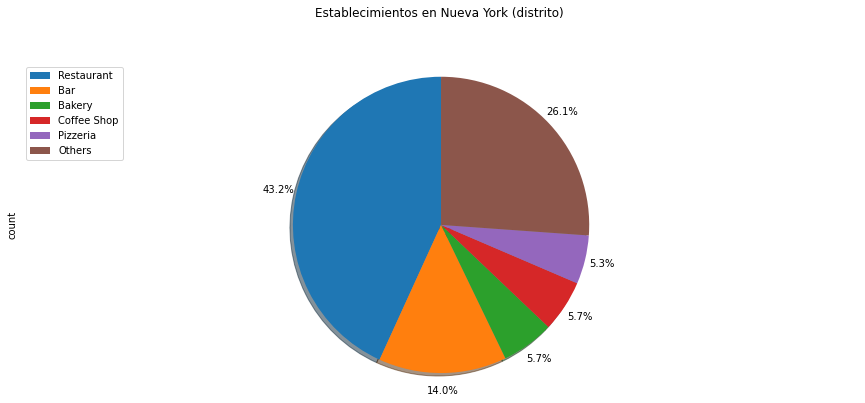

In [71]:
District_New_York_6 = District_New_York[District_New_York['count']>District_New_York.iloc[5,1]]
District_New_York_6 = District_New_York_6.append({'Category':'Others','count':District_New_York[District_New_York['count']<=District_New_York.iloc[5,1]].sum()['count']},ignore_index=True)
plot_place(District_New_York_6,'Nueva York (distrito)')

La siguiente tabla presenta la cantidad de establecimientos por categoría para el distrito de Brooklyn:

In [59]:
D_Brooklyn = NY[NY['Borough'] == 'Brooklyn']
District_Brooklyn = pd.DataFrame({'count' : D_Brooklyn.groupby(['Category'])['fsq_id'].size()}).reset_index()
filt1 = ~District_Brooklyn['Category'].str.contains('Restaurant')
filt3 = ~District_Brooklyn['Category'].str.contains('Bar')
District_Brooklyn = District_Brooklyn[filt1 & filt3]
Rest = pd.DataFrame({'count':D_Brooklyn[D_Brooklyn['Category'].str.contains('Restaurant')].groupby(['Category'])['fsq_id'].size()}).reset_index()
Restaurant = Rest['count'].sum()
B = pd.DataFrame({'count':D_Brooklyn[D_Brooklyn['Category'].str.contains('Bar')].groupby(['Category'])['fsq_id'].size()}).reset_index()
Bar = B['count'].sum()
District_Brooklyn = District_Brooklyn.append({'Category':'Restaurant','count':Restaurant},ignore_index=True)
District_Brooklyn = District_Brooklyn.append({'Category':'Bar','count':Bar},ignore_index=True)
District_Brooklyn.sort_values(['count'],ascending=False,inplace=True)
District_Brooklyn.head(9)

,Category,count
28,Restaurant,344
29,Bar,115
23,Pizzeria,81
12,Deli,62
2,Bakery,53
11,Coffee Shop,38
10,Café,37
1,Bagel Shop,36
8,Burger Joint,24


Gráfico circular que representa la cantidad porcentual de establecimientos en el distrito de Brooklyn:

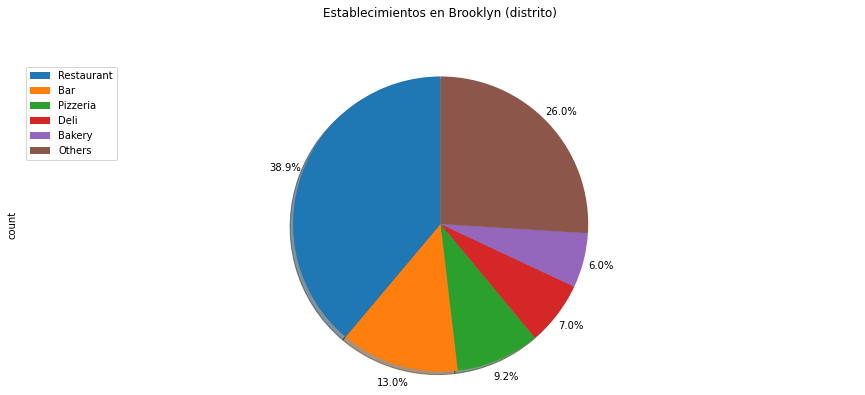

In [72]:
District_Brooklyn_6 = District_Brooklyn[District_Brooklyn['count']>District_Brooklyn.iloc[5,1]]
District_Brooklyn_6 = District_Brooklyn_6.append({'Category':'Others','count':District_Brooklyn[District_Brooklyn['count']<=District_Brooklyn.iloc[5,1]].sum()['count']},ignore_index=True)
plot_place(District_Brooklyn_6,'Brooklyn (distrito)')

La siguiente tabla presenta la cantidad de establecimientos por categoría para el distrito de Bronx:

In [64]:
D_Bronx = NY[NY['Borough'] == 'Bronx']
District_Bronx = pd.DataFrame({'count' : D_Bronx.groupby(['Category'])['fsq_id'].size()}).reset_index()

filt1 = ~District_Bronx['Category'].str.contains('Restaurant')
filt3 = ~District_Bronx['Category'].str.contains('Bar')
District_Bronx = District_Bronx[filt1 & filt3]

Rest = pd.DataFrame({'count':D_Bronx[D_Bronx['Category'].str.contains('Restaurant')].groupby(['Category'])['fsq_id'].size()}).reset_index()
Restaurant = Rest['count'].sum()
B = pd.DataFrame({'count':D_Bronx[D_Bronx['Category'].str.contains('Bar')].groupby(['Category'])['fsq_id'].size()}).reset_index()
Bar = B['count'].sum()

District_Bronx = District_Bronx.append({'Category':'Restaurant','count':Restaurant},ignore_index=True)
District_Bronx = District_Bronx.append({'Category':'Bar','count':Bar},ignore_index=True)

District_Bronx.sort_values(['count'],ascending=False,inplace=True)
District_Bronx.head(9)

,Category,count
24,Restaurant,188
9,Deli,69
21,Pizzeria,57
25,Bar,34
2,Bakery,22
16,Fried Chicken Joint,18
1,Bagel Shop,17
6,Burger Joint,16
7,Café,13


Gráfico circular que representa la cantidad porcentual de establecimientos en el distrito de Bronx:

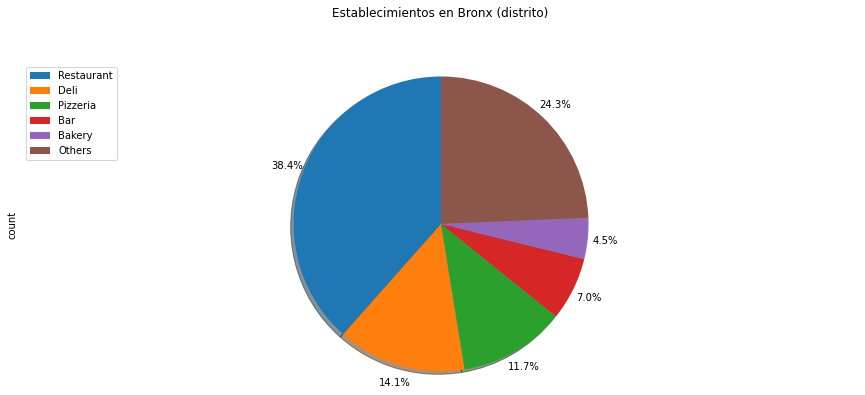

In [73]:
District_Bronx_6 = District_Bronx[District_Bronx['count']>District_Bronx.iloc[5,1]]
District_Bronx_6 = District_Bronx_6.append({'Category':'Others','count':District_Bronx[District_Bronx['count']<=District_Bronx.iloc[5,1]].sum()['count']},ignore_index=True)
plot_place(District_Bronx_6,'Bronx (distrito)')

## Análisis
Se puede observar que los distritos estudiados tienen diferentes distribuciones en cuanto a la cantidad de establecimientos y sus respectivas categorías. Analizando las tres primeras mayorias se puede establecer, a grandes rasgos, el comportamiento de sus habitantes y, en consecuencia, hacia donde deben ir enfocados los esfuerzos de nuestros clientes. \
Para Toronto, las primeras mayorias corresponden a Restaurant, Bar y Cafe, sumando estas un 59.7% de los establecimientos. Una posible lectura para esta información es que los habitantes tienden a asistir a estos lugares despues del trabajo o los fines de semana con tal de hacer vida social.

Para el caso de Nueva York (distrito), el 57.2% de los establecimientos estan repartidos entre Restaurant y Bar. Además, si observamos la siguiente tabla, podemos ver que las tres primeras mayorias en cuanto a la categoría Bar son: Cocktail Bar, Bar y Wine Bar. Todo esto en conjunto señala que los habitantes de este distrito tienden a la vida nocturna y a ambientes más sofisticados.

In [77]:
Tab_1 = pd.DataFrame({'count' : D_NY.groupby(['Category'])['fsq_id'].size()}).reset_index()
Tab_1[Tab_1['Category'].str.contains('Bar')].sort_values(['count'],ascending=False)

,Category,count
24,Cocktail Bar,51
7,Bar,38
96,Wine Bar,23
8,Beer Bar,13
56,Juice Bar,11
81,Sports Bar,10
32,Dive Bar,7
57,Karaoke Bar,5
46,Hookah Bar,1
48,Hotel Bar,1


Para el caso de Brooklyn, aproximadamente el 60% de los establecimientos estan repartidos entre Restaurant, Bar y Pizzeria. Esto indica que los habitantes de brooklyn tienden a llevar un estilo de vida correspondiente a trabajadores de clase media, observación que se hace en base a que la primera mayoría para la categoría Restaurant corresponde a comida china (ver tabla).

In [79]:
Tab_1 = pd.DataFrame({'count' : D_Brooklyn.groupby(['Category'])['fsq_id'].size()}).reset_index()
Tab_1[Tab_1['Category'].str.contains('Restaurant')].sort_values(['count'],ascending=False)[:10]

,Category,count
21,Chinese Restaurant,62
69,Restaurant,41
1,American Restaurant,36
20,Caribbean Restaurant,24
78,Sushi Restaurant,19
62,Mexican Restaurant,19
2,Asian Restaurant,16
35,Fast Food Restaurant,15
52,Italian Restaurant,15
59,Latin American Restaurant,11


En el caso del Bronx, en torno al 63% de los establecimientos estan repartidos entre Restaurant, Deli y Pizzerias. Considerando que los Deli corresponden a lugares donde se compra comida "por gramo", se puede inferir que los habitantes del distrito utilizan estos servicios mayoritariamente para subsistir y no tanto de forma recreacional.

## Conclusión
En conclusión, se tiene que tomar en cuenta las preferencias de los habitantes de los diferentes distritos para instalar un establecimiento de comida. En el caso de Toronto, el distrito de Toronto es una buena opción y el tipo de negocio debiese estar enfocado a captar clientes que buscan un lugar para disfrutar la tarde mientras leen un libro o comparten con sus amistades. Para el caso de Nueva York, los distritos mas convenientes son: Nueva York, Brooklyn y Bronx. \
En el caso del primero, hay que considerar que quienes frecuentan este distrito buscan un ambiente nocturno y sofisticado por lo que convendría un establecimiento de alta gama. En el caso de Brooklyn, sus habitantes buscan establecimientos dentro de lo "normal" para la cultura americana por lo que un Bar con variedad de cervezas y whisky sería una buena opción. Por último, los habitantes del Bronx prefieren los lugares donde se puede comer por buenos precios por lo que un restaurant con precios bajos y buenas ofertas sería una buena alternativa.